In [3]:
import networkit as nk 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [4]:
import networkx as nx 

In [5]:
import os 

# General Callgraphs: Scale-Free Exploration 

### Use the largest weakly connected component in place of the whole callgraph

In [6]:
callgraphMetrics        = {} 
callgraphs              = {}
callgraph_vs_wcc_ratios = {} 
for file in os.listdir('/logs'):
    filepath     = '/'.join(['/logs', file])
    if os.path.isfile(filepath): 
        if 'TrilinosCG' in file: 
            file_pd                    = pd.read_csv(filepath)
            callgraphMetrics[filepath] = file_pd 
        if 'TrilinosGR' in file: 
            file_nx              = nx.read_edgelist(filepath, create_using=nx.DiGraph())
            file_nk              = nk.nxadapter.nx2nk(file_nx)
            wcc                  = nk.components.WeaklyConnectedComponents(file_nk)
            wcc.run()
            components           = wcc.getComponents()
            largst_wcc_l         = [x for x in components if len(x) == max(len(y) for y in components)]
            largst_wcc           = largst_wcc_l[0]
            sample_gr_lwcc       = nk.graphtools.subgraphFromNodes(file_nk, largst_wcc)
            callgraphs[filepath] = sample_gr_lwcc
            

In [7]:
data_p_year = {}
for k in callgraphs.keys(): 
        k_l = k.split('.') 
        k_l_y = k_l[0][-4:]
        if k_l_y in data_p_year.keys():
            data_p_year[k_l_y].append(k) 
        else: 
            data_p_year[k_l_y] = [k]

In [8]:
data_p_year

{'osGR': ['/logs/TrilinosGR.TabOne'],
 '1300': ['/logs/TrilinosGR1300.TabOne'],
 '1301': ['/logs/TrilinosGR1301.TabOne'],
 '1320': ['/logs/TrilinosGR1320.TabOne'],
 '2015': ['/logs/TrilinosGRApr16th2015.TabOne',
  '/logs/TrilinosGRApr21st2015.TabOne',
  '/logs/TrilinosGRAug6th2015.TabOne',
  '/logs/TrilinosGRJan22nd2015.TabOne',
  '/logs/TrilinosGRJul14th2015.TabOne',
  '/logs/TrilinosGRMar6th2015.TabOne',
  '/logs/TrilinosGRMay7th2015.TabOne',
  '/logs/TrilinosGRNov12th2015.TabOne',
  '/logs/TrilinosGRNov3rd2015.TabOne',
  '/logs/TrilinosGROct6th2015.TabOne'],
 '2016': ['/logs/TrilinosGRApr21st2016.TabOne',
  '/logs/TrilinosGRApr28th2016.TabOne',
  '/logs/TrilinosGRFeb9th2016.TabOne',
  '/logs/TrilinosGRJan12th2016.TabOne',
  '/logs/TrilinosGRJan28th2016.TabOne',
  '/logs/TrilinosGRJul12th2016.TabOne',
  '/logs/TrilinosGRJul26th2016.TabOne',
  '/logs/TrilinosGRNov22nd2016.TabOne',
  '/logs/TrilinosGRNov9th2016.TabOne'],
 '2014': ['/logs/TrilinosGRApr29th2014.TabOne',
  '/logs/Trilinos

In [9]:
ordered_versions = [
  'osCG', 'osGR', '1320', '1301', '1300', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013'
]

In [10]:
version_indices = {k : ordered_versions.index(k) for k in ordered_versions}

In [11]:
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [12]:
months_indices = {k : ordered_months.index(k) for k in ordered_months}

In [13]:
days_indices = range(30)

In [14]:
def get_graph_filename_year(graph): 
    return graph.split('.')[0][-4:]

In [15]:
def get_graph_filename_month(graph): 
    for m in ordered_months: 
        if m in graph: 
            return m 

In [16]:
def get_graph_filename_day(graph): 
    p_matches = []
    for d in days_indices: 
        postfixes = ['rd', 'th', 'st', 'nd']  
        for p in postfixes: 
#             print(str(d) + p)
            if (str(d) + p) in graph: 
                p_matches.append(d)
    if p_matches != []:
        return max(p_matches) 
    else: 
        return 0 

In [17]:
get_graph_filename_year('/logs/TrilinosGRMay5th2020.TabOne')

'2020'

In [18]:
get_graph_filename_month('/logs/TrilinosGRMay5th2020.TabOne')

'May'

In [19]:
get_graph_filename_day('/logs/TrilinosGRMay5th2020.TabOne')

5

In [20]:
get_graph_filename_day('/logs/TrilinosGROct23rd2014.TabOne')

23

In [21]:
def compare_graph_filenames(graph1, graph2): 
    # returns whether graph1's date is earlier 
    # than graph2's date 
    # since years, and months in our lists above are ascending, use >
    if version_indices[get_graph_filename_year(graph1)] > version_indices[get_graph_filename_year(graph2)]: 
        return -1  
    elif version_indices[get_graph_filename_year(graph1)] == version_indices[get_graph_filename_year(graph2)]:
        if months_indices[get_graph_filename_month(graph1)] < months_indices[get_graph_filename_month(graph2)]: 
            return -1 
        elif months_indices[get_graph_filename_month(graph1)] == months_indices[get_graph_filename_month(graph2)]:
            if get_graph_filename_day(graph1) < get_graph_filename_day(graph2): 
                return -1 
            elif get_graph_filename_day(graph1) == get_graph_filename_day(graph2):
                return 0 
            else: 
                return 1 
        else: 
            return 1  
    else: 
        return 1 

In [22]:
compare_graph_filenames('/logs/TrilinosGROct8th2014.TabOne', '/logs/TrilinosGRJul15th2014.TabOne')

1

In [23]:
from functools import cmp_to_key 

In [24]:
def sort_graphs(graphs_list): 
    return sorted(graphs_list, key=cmp_to_key(compare_graph_filenames))

In [25]:
sorted_callgraph_keys        = sort_graphs(callgraphs.keys())
sorted_callgraph_keys

['/logs/TrilinosGRJul11th2013.TabOne',
 '/logs/TrilinosGROct23rd2013.TabOne',
 '/logs/TrilinosGRJan14th2014.TabOne',
 '/logs/TrilinosGRJan29th2014.TabOne',
 '/logs/TrilinosGRApr29th2014.TabOne',
 '/logs/TrilinosGRMay16th2014.TabOne',
 '/logs/TrilinosGRJul15th2014.TabOne',
 '/logs/TrilinosGRAug5th2014.TabOne',
 '/logs/TrilinosGROct8th2014.TabOne',
 '/logs/TrilinosGROct23rd2014.TabOne',
 '/logs/TrilinosGRJan22nd2015.TabOne',
 '/logs/TrilinosGRMar6th2015.TabOne',
 '/logs/TrilinosGRApr16th2015.TabOne',
 '/logs/TrilinosGRApr21st2015.TabOne',
 '/logs/TrilinosGRMay7th2015.TabOne',
 '/logs/TrilinosGRJul14th2015.TabOne',
 '/logs/TrilinosGRAug6th2015.TabOne',
 '/logs/TrilinosGROct6th2015.TabOne',
 '/logs/TrilinosGRNov3rd2015.TabOne',
 '/logs/TrilinosGRNov12th2015.TabOne',
 '/logs/TrilinosGRJan12th2016.TabOne',
 '/logs/TrilinosGRJan28th2016.TabOne',
 '/logs/TrilinosGRFeb9th2016.TabOne',
 '/logs/TrilinosGRApr21st2016.TabOne',
 '/logs/TrilinosGRApr28th2016.TabOne',
 '/logs/TrilinosGRJul12th2016.Tab

In [26]:
sorted_callgraphMetrics_keys = sort_graphs(callgraphMetrics.keys())

why read using networkx and then convert to networkit thereby adding extra conversion-time, you ask? Because apparently networkit has no easy way of reading directed graphs. 

In [27]:
list(callgraphs.keys())[:5]

['/logs/TrilinosGR.TabOne',
 '/logs/TrilinosGR1300.TabOne',
 '/logs/TrilinosGR1301.TabOne',
 '/logs/TrilinosGR1320.TabOne',
 '/logs/TrilinosGRApr16th2015.TabOne']

In [28]:
nk.overview(list(callgraphs.values())[0])

Network Properties:
nodes, edges			21020, 101875
directed?			True
weighted?			False
isolated nodes			2983
self-loops			258
density				0.000230
min/max/avg degree		0, 294, 4.846575
degree assortativity		0.058990
number of connected components	20979
size of largest component	7 (0.03 %)


In [29]:
len(callgraphs.values())

41

In [30]:
list(callgraphMetrics.values())[0].head()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
0,0,_ZNK6shards11ArrayDimTag9to_stringB5cxx11Eii,0,9,False,1975.4,0.000506,0.0,2,15
1,1,_ZN6shards12array_traits11check_rangeEii,2,10,False,2116.5,0.000472,16.0,1,9
2,2,_ZNSt7__cxx1119basic_ostringstreamIcSt11char_t...,1138,0,False,inf,0.000000,0.0,0,2
3,3,_ZNSolsEi,1014,0,False,inf,0.000000,0.0,0,3
4,4,_ZNSt7__cxx1112basic_stringIcSt11char_traitsIc...,608,0,False,inf,0.000000,0.0,0,4


Note that for every CG and GR file, there exists a corresponding NM file. Thus, even though the C++ identifiers are kept mangled, one can easily 
unmangle them by piping the contents of the file through c++filt. 

Moreover, if the average shortest path of a given node is infinite, this should mean that  
there exists at least one node in the network that the node in question is not connected to. If, in addition, the node's fan-out is zero, then all paths end at the node, and thus is betweenness is zero. For our problem domain, nodes are functions and for a function to be such an end-point, the function would have to be a built-in function.  We drop such built-in functions.

In [31]:
sample_pd = callgraphMetrics['/logs/TrilinosCG1301.csv'][['FanIn', 'FanOut', 'AvgShortestPath', 'Betweenness', 'Eccentricity_R']]

In [32]:
sample_gr = callgraphs['/logs/TrilinosGR1301.TabOne']

In [33]:
import math 

In [34]:
ans   = True 
count = 0
counterex = []
for i in sample_pd.index: 
    if sample_pd.AvgShortestPath[i] == math.inf: 
        if sample_pd.FanOut[i] == 0: 
            if sample_pd.Betweenness[i] != 0:
                ans = False 
                count += 1 
                counterex.append((i, sample_pd.FanOut[i]))
print(ans) 
print(count)
print(counterex)

True
0
[]


Our condition holds, and we proceed to drop

In [35]:
sample_pd = sample_pd.drop(
              sample_pd[
                  (sample_pd.AvgShortestPath == math.inf) & 
                  (sample_pd.FanOut == 0) 
              ].index 
            )

In [36]:
sample_pd = sample_pd.drop(sample_pd[sample_pd.AvgShortestPath == math.inf].index)

### Fan-In & Fan-Out

#### single version

In [37]:
sample_pd_fanin  = sample_pd.FanIn.value_counts().rename_axis('unique_fanins').reset_index(name='counts')
sample_pd_fanout = sample_pd.FanOut.value_counts().rename_axis('unique_fanouts').reset_index(name='counts')

In [38]:
sample_pd_fanin['probs'] = sample_pd_fanin['counts'] / sample_pd_fanin['counts'].sum()
sample_pd_fanout['probs'] = sample_pd_fanout['counts'] / sample_pd_fanout['counts'].sum()

In [39]:
sample_pd_fanin.head()

,unique_fanins,counts,probs
0,1,7813,0.437360
1,0,6403,0.358430
2,2,1929,0.107983
3,3,488,0.027318
4,4,305,0.017073


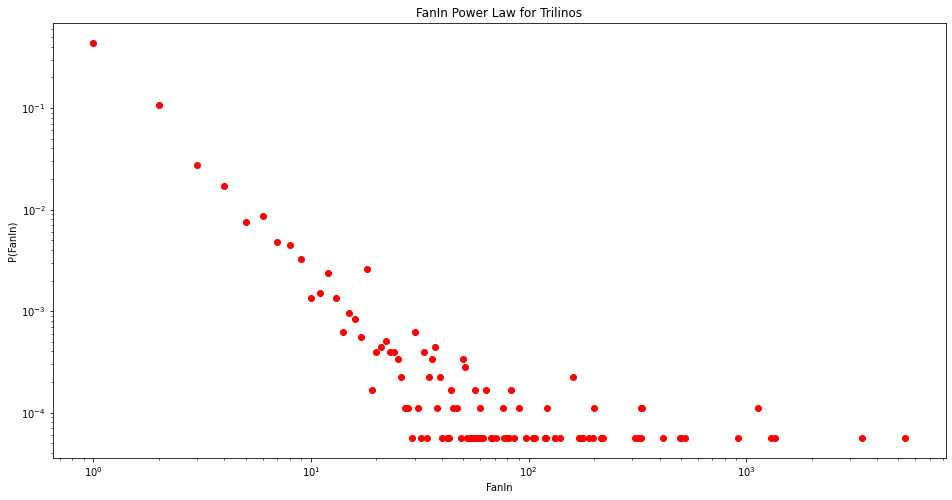

In [40]:
fig = plt.figure(figsize=(16, 8)) 
ax = plt.gca()
ax.scatter(sample_pd_fanin.unique_fanins, sample_pd_fanin.probs, color='r')
# ax.plot(np.unique(sample_pd_fanin.unique_fanins), 
#                 np.poly1d(np.polyfit(sample_pd_fanin.unique_fanins, 
#                                      sample_pd_fanin.probs, 1))
#         (np.unique(sample_pd_fanin.unique_fanins)))
ax.set_yscale('log') 
ax.set_xscale('log')
ax.set_title('FanIn Power Law for Trilinos')
ax.set_xlabel('FanIn') 
ax.set_ylabel('P(FanIn)')
fig.savefig('Trilinos1301FanInPowerLaw.png')

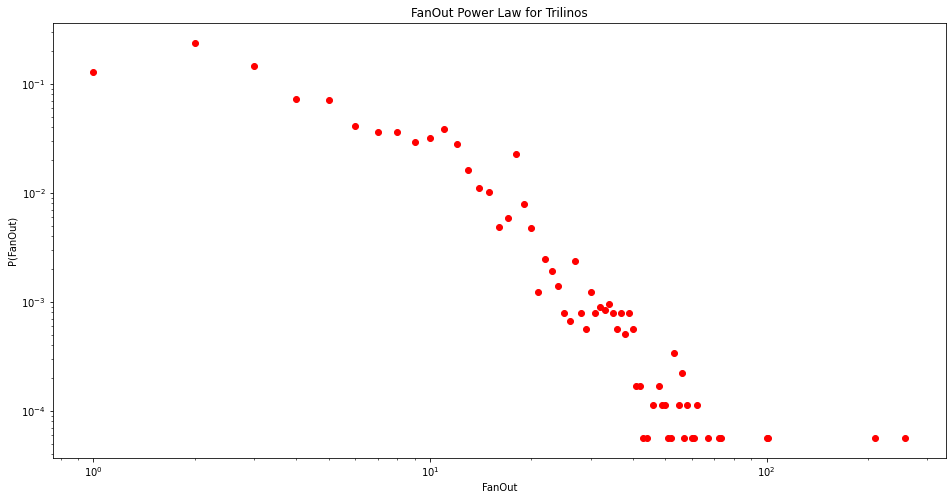

In [41]:
fig = plt.figure(figsize=(16, 8)) 
ax = plt.gca()
ax.scatter(sample_pd_fanout.unique_fanouts, sample_pd_fanout.probs, color='r')
# ax.plot(np.unique(np.log(sample_pd_fanout.unique_fanouts)), np.poly1d(np.polyfit(np.log(sample_pd_fanout.unique_fanouts), np.log(sample_pd_fanout.probs), 1))(np.unique(np.log(sample_pd_fanout.unique_fanouts))), ':')
ax.set_yscale('log') 
ax.set_xscale('log')
ax.set_title('FanOut Power Law for Trilinos')
ax.set_xlabel('FanOut') 
ax.set_ylabel('P(FanOut)')
plt.savefig('Trilinos1301FanOutPowerLaw.png')

Since the probabilities P(FanIn) and P(FanOut) seem to be in a linear relationship with negative slope to FanIn and FanOut values respectively, it follows that Trilinos' overall callgraph (for this version) seems to be small-world network.

# General Callgraphs: Small-World Exploration

A *Small-World Network* is a simple connected graph G exhibiting two properties:
     - **Large Clustering Coefficient**: Each vertex of G is linked to a relatively well-connected set of neighboring vertices, resulting in a large value for the clustering coefficient C(G). 
     - **Small Characteristic Path Length** The presence of short-cut connections between some vertices results in a small characteristic path length L(G).

In [42]:
sample_pd.size 

89320

In [43]:
sample_pd.AvgShortestPath.sum() / sample_pd.size  

1024.9407797386668

In [44]:
ed = nk.distance.EffectiveDiameter(nk.graphtools.toUndirected(sample_gr))
ed.run()
diameter = ed.getEffectiveDiameter()

**N.B: It is weird that average shortest path should be so large when the effective diameter of the graph is so small. Doesn't it follow that the diameter of a graph is always greater than or equal to its average shortest path? This makes me think that average shortest path calculation (which is currently being calculated as the reciprocal of the closeness centrality metric) is most likely wrong!!!**

It turns out that what we calculate as the average shortest path for every node using avg(i) = 1 / closeness(i) is in fact **not the average shortest path, but *farness***. However, a close relationship between these values and the degree distribution of nodes has also been found. this value, 1 / c is in a linear logarithmic relationship with deg(i).

In [45]:
sample_pd.columns

Index(['FanIn', 'FanOut', 'AvgShortestPath', 'Betweenness', 'Eccentricity_R'], dtype='object')

In [46]:
sample_pd.Eccentricity_R.mean()

3.248320644872369

In [47]:
sample_pd_fanin.max()

unique_fanins    5386.00000
counts           7813.00000
probs               0.43736
dtype: float64

In [48]:
np.log(5464)

8.605936401250625

If the eccentricity of a given node represents its maximum shortest path from the node to any other node in the network, then the average eccentricity in a network should always be greater than its all-pairs average shortest path. Consequently, if the average eccentricity of a network is relatively small, then its average shortest path is relatively small also, and the second property of small-world networks can be verified by confirming that this average eccentricity stays small as the network evolves: 

In [49]:
avg_eccentricities = {}
for f, f_pd in callgraphMetrics.items(): 
    f_pd = f_pd.drop(
              f_pd[
                  (f_pd.AvgShortestPath == math.inf) & 
                  (f_pd.FanOut == 0) 
              ].index 
            )
    avg_eccentricities[f] = f_pd.Eccentricity_R.mean() 

In [50]:
sorted_eccentricities = [0] * len(sorted_callgraphMetrics_keys) 
for i, f in enumerate(sorted_callgraphMetrics_keys): 
    sorted_eccentricities[i] = avg_eccentricities[f]

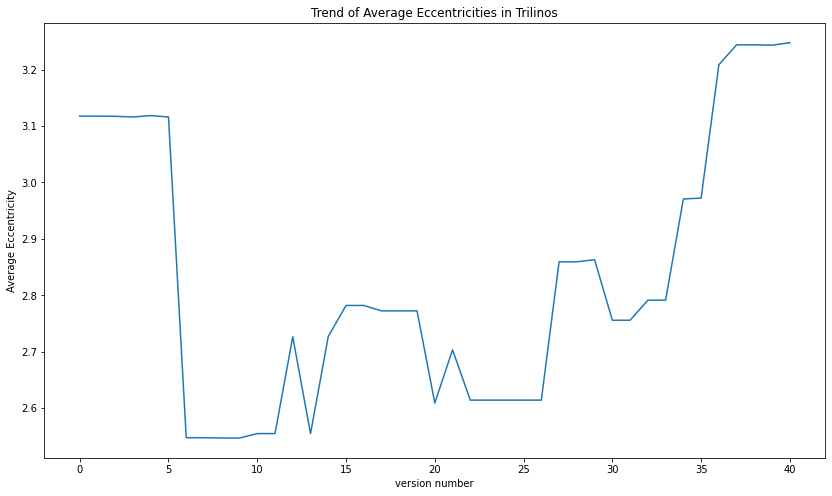

In [51]:
fig, ax1 = plt.subplots(figsize=(14,8), nrows=1, ncols=1)
ax1.plot(sorted_eccentricities)
ax1.set_xlabel('version number')
ax1.set_ylabel('Average Eccentricity') 
ax1.set_title('Trend of Average Eccentricities in Trilinos')
plt.savefig('TrilinosAverageEccentricityTrend.png')

What caused the drop from 5 to 6, and waht is going on where the average eccentricity is constant 

In [52]:
sorted_callgraphMetrics_keys[5:12]

['/logs/TrilinosCGMay16th2014.csv',
 '/logs/TrilinosCGJul15th2014.csv',
 '/logs/TrilinosCGAug5th2014.csv',
 '/logs/TrilinosCGOct8th2014.csv',
 '/logs/TrilinosCGOct23rd2014.csv',
 '/logs/TrilinosCGJan22nd2015.csv',
 '/logs/TrilinosCGMar6th2015.csv']

In [53]:
sum(avg_eccentricities.values()) / len(avg_eccentricities.values())

2.8311943655225895

In [54]:
gr_sizes = {} 
for f, f_gr in callgraphs.items(): 
    num_nodes = f_gr.numberOfNodes() 
    gr_sizes[f] = num_nodes 

In [55]:
sorted_gr_sizes = [0] * len(sorted_callgraphMetrics_keys) 
for i, f in enumerate(sorted_callgraph_keys): 
    sorted_gr_sizes[i] = gr_sizes[f]

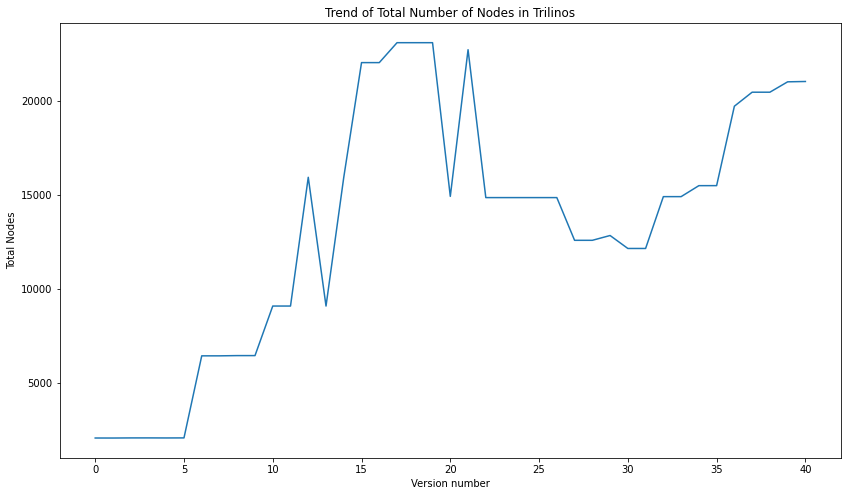

In [56]:
fig, ax1 = plt.subplots(figsize=(14,8), nrows=1, ncols=1)
ax1.plot(sorted_gr_sizes)
ax1.set_xlabel('Version number')
ax1.set_ylabel('Total Nodes') 
ax1.set_title('Trend of Total Number of Nodes in Trilinos')
plt.savefig('TrilinosTotalNodesTrend.png')

In [57]:
gr_sizes_edges = {} 
for f, f_gr in callgraphs.items(): 
    num_edges = f_gr.numberOfEdges() 
    gr_sizes_edges[f] = num_edges 

In [58]:
gr_sizes_edges

{'/logs/TrilinosGR.TabOne': 101875,
 '/logs/TrilinosGR1300.TabOne': 105469,
 '/logs/TrilinosGR1301.TabOne': 105469,
 '/logs/TrilinosGR1320.TabOne': 101746,
 '/logs/TrilinosGRApr16th2015.TabOne': 74304,
 '/logs/TrilinosGRApr21st2015.TabOne': 43773,
 '/logs/TrilinosGRApr21st2016.TabOne': 70697,
 '/logs/TrilinosGRApr28th2016.TabOne': 70697,
 '/logs/TrilinosGRApr29th2014.TabOne': 6650,
 '/logs/TrilinosGRAug5th2014.TabOne': 32838,
 '/logs/TrilinosGRAug6th2015.TabOne': 100396,
 '/logs/TrilinosGRFeb20th2017.TabOne': 66740,
 '/logs/TrilinosGRFeb27th2019.TabOne': 74897,
 '/logs/TrilinosGRFeb9th2016.TabOne': 70694,
 '/logs/TrilinosGRJan12th2016.TabOne': 70977,
 '/logs/TrilinosGRJan14th2014.TabOne': 6659,
 '/logs/TrilinosGRJan22nd2015.TabOne': 43773,
 '/logs/TrilinosGRJan28th2016.TabOne': 106030,
 '/logs/TrilinosGRJan29th2014.TabOne': 6661,
 '/logs/TrilinosGRJul11th2013.TabOne': 6618,
 '/logs/TrilinosGRJul12th2016.TabOne': 70697,
 '/logs/TrilinosGRJul14th2015.TabOne': 100396,
 '/logs/TrilinosGRJu

In [59]:
sorted_gr_sizes_edges = [0] * len(sorted_callgraphMetrics_keys) 
sorted_gr_possible_edges = [N * (N - 1) for N in sorted_gr_sizes]
for i, f in enumerate(sorted_callgraph_keys): 
    sorted_gr_sizes_edges[i] = gr_sizes_edges[f]

In [60]:
sorted_gr_sizes_edges

[6618,
 6617,
 6659,
 6661,
 6650,
 6661,
 32838,
 32838,
 32940,
 32940,
 43773,
 43773,
 74304,
 43773,
 74312,
 100396,
 100396,
 107321,
 107321,
 107321,
 70977,
 106030,
 70694,
 70697,
 70697,
 70697,
 70694,
 65501,
 65501,
 66740,
 60526,
 60526,
 74897,
 74897,
 77677,
 77681,
 100242,
 105469,
 105469,
 101746,
 101875]

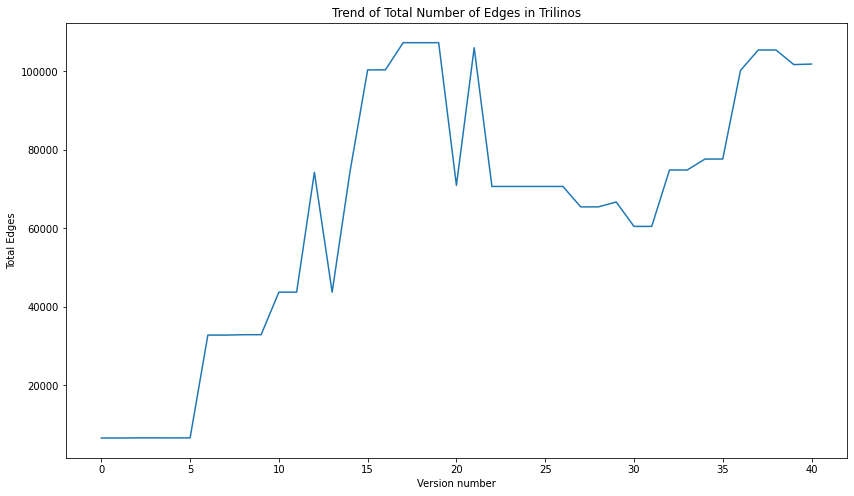

In [61]:
fig, ax1 = plt.subplots(figsize=(14,8), nrows=1, ncols=1)
ax1.plot(sorted_gr_sizes_edges)
# ax1.plot(sorted_gr_possible_edges, color='red')
ax1.set_xlabel('Version number')
ax1.set_ylabel('Total Edges') 
ax1.set_title('Trend of Total Number of Edges in Trilinos')
plt.savefig('TrilinosTotalEdgesTrend.png')

In [62]:
sum(gr_sizes.values()) / len(gr_sizes.values())

13377.756097560976

Clearly these eccentricities, staying between 2.5 and 3.3, are relatively small compared to the number of edges in each network (between 10k and 110k). Thus, we can conclude that, on average, it takes a maximum of around 3 hops for any function in the callgraph (of around 64472 nodes on average) to call any other function in the Trilinos---a characteristic which might have implications relating to propagation of bugs in the software, for example.

In [63]:
nk.globals.clustering(sample_gr)

0.07747763397898029

In [64]:
sample_gr_nx = nk.nxadapter.nk2nx(sample_gr)
nx.average_clustering(sample_gr_nx)

0.0973418384208563

**Are 7% or 9% small values of the clustering coefficient?**

### WattsStrogatz Model Comparison

In [65]:
watts_strog_graphs = {} 
limit_watts = {}
watts_theoretical_clusts = {}
erdos_theoretical_clusts = {}
for f, g in callgraphs.items(): 
    g_nodes = g.numberOfNodes() 
    g_edges = g.numberOfEdges() 
    metric_fname = f.replace('GR', 'CG')
    metric_fname = metric_fname.replace('.TabOne', '.csv')
    K            = (callgraphMetrics[metric_fname].FanIn.mean() + callgraphMetrics[metric_fname].FanOut.mean()) / 2
    g_possible_edges      = g_nodes * K / 2
    p                     = g_edges / g_possible_edges
    limit_watts[f]        = 3 / (1+p**2)
    watts_theoretical_clusts[f] = 3*K*(K-1) / (2*K*(2*K - 1) + 8*p*K**2 + 4*p**2*K**2)  
    erdos_theoretical_clusts[f] = K / g_nodes 
    g_wattsStrog                = nk.generators.WattsStrogatzGenerator(g_nodes, K, p)
    g_wattsStrogG               = g_wattsStrog.generate() 
    watts_strog_graphs[f]       = g_wattsStrogG 

In [66]:
real_clusters = {} 
for f, g in callgraphs.items(): 
    g_nx = nk.nxadapter.nk2nx(g)
    C                = nx.average_clustering(g_nx) 
    real_clusters[f] = C 
    
watts_clusters           = {} 
for k in real_clusters.keys():  
    g_nx = nk.nxadapter.nk2nx(watts_strog_graphs[f])
    watts_clusters[k] = nx.average_clustering(g_nx)

In [67]:
pd_real_C            = pd.DataFrame.from_dict(real_clusters, columns=['Coefficient'], orient='index')
pd_watts_C           = pd.DataFrame.from_dict(watts_clusters, columns=['WattsCoefficient'], orient='index')
pd_limit_watts       = pd.DataFrame.from_dict(limit_watts, columns=['LimitInftyCoefficient'], orient='index')
pd_watts_theoretical = pd.DataFrame.from_dict(watts_theoretical_clusts, columns=['Coefficient'], orient='index')
pd_erdos_theoretical = pd.DataFrame.from_dict(erdos_theoretical_clusts, columns=['Coefficient'], orient='index')
pd_real_C.head()

,Coefficient
/logs/TrilinosGR.TabOne,0.095970
/logs/TrilinosGR1300.TabOne,0.097342
/logs/TrilinosGR1301.TabOne,0.097342
/logs/TrilinosGR1320.TabOne,0.095919
/logs/TrilinosGRApr16th2015.TabOne,0.112047


In [68]:
pd_watts_C.head()

,WattsCoefficient
/logs/TrilinosGR.TabOne,0.000664
/logs/TrilinosGR1300.TabOne,0.000664
/logs/TrilinosGR1301.TabOne,0.000664
/logs/TrilinosGR1320.TabOne,0.000664
/logs/TrilinosGRApr16th2015.TabOne,0.000664


In [69]:
pd_limit_watts.head()

,LimitInftyCoefficient
/logs/TrilinosGR.TabOne,0.594334
/logs/TrilinosGR1300.TabOne,0.594965
/logs/TrilinosGR1301.TabOne,0.594965
/logs/TrilinosGR1320.TabOne,0.593855
/logs/TrilinosGRApr16th2015.TabOne,0.596004


In [70]:
pd_watts_theoretical.head()

,Coefficient
/logs/TrilinosGR.TabOne,0.066275
/logs/TrilinosGR1300.TabOne,0.067344
/logs/TrilinosGR1301.TabOne,0.067344
/logs/TrilinosGR1320.TabOne,0.066215
/logs/TrilinosGRApr16th2015.TabOne,0.065809


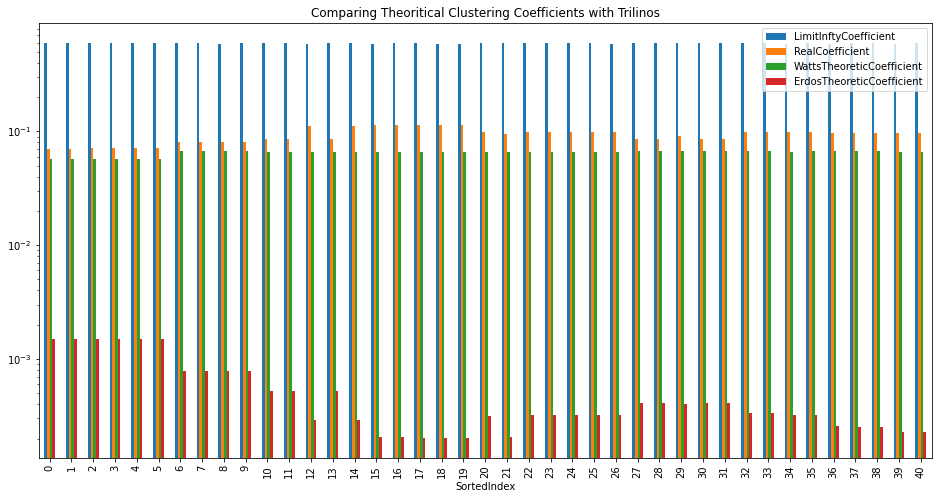

In [71]:
fig, ax1 = plt.subplots(figsize=(16,8), nrows=1, ncols=1) 
pd_limit_watts['SortedIndex'] = sorted_callgraph_keys
pd_limit_watts = pd_limit_watts.set_index(keys=['SortedIndex'])
pd_limit_watts['RealCoefficient']       = pd_real_C['Coefficient']
pd_limit_watts['WattsTheoreticCoefficient']  = pd_watts_theoretical['Coefficient']
pd_limit_watts['ErdosTheoreticCoefficient']  = pd_erdos_theoretical['Coefficient']
ax1.set_title('Comparing Theoritical Clustering Coefficients with Trilinos')
plot = pd_limit_watts.plot.bar(ax=ax1, logy=True)
fig = plot.get_figure() 
ax1.set_xticklabels(range(pd_limit_watts['RealCoefficient'].size))
fig.savefig('ClusteringWattsStrog.png') 

In [72]:
pd_limit_watts.head()

,LimitInftyCoefficient,RealCoefficient,WattsTheoreticCoefficient,ErdosTheoreticCoefficient
SortedIndex,,,,
/logs/TrilinosGRJul11th2013.TabOne,0.594334,0.070576,0.056600,0.001494
/logs/TrilinosGROct23rd2013.TabOne,0.594965,0.070611,0.056608,0.001495
/logs/TrilinosGRJan14th2014.TabOne,0.594965,0.071440,0.056699,0.001496
/logs/TrilinosGRJan29th2014.TabOne,0.593855,0.071406,0.056696,0.001495
/logs/TrilinosGRApr29th2014.TabOne,0.596004,0.070866,0.056688,0.001497


In [73]:
RSS = (pd_limit_watts['WattsTheoreticCoefficient'] - pd_limit_watts['RealCoefficient']).apply(lambda x: x**2).sum()

In [74]:
RSS 

0.03601217651663841

In [75]:
SD = math.sqrt((pd_limit_watts['RealCoefficient'] - pd_limit_watts['RealCoefficient'].mean()).apply(lambda x: x**2).sum())

In [76]:
SD 

0.083195021892925

In [77]:
RSD = math.sqrt(RSS / (pd_limit_watts['WattsTheoreticCoefficient'].size - 2)) 

In [78]:
RSD 

0.03038731876050052

---

### TODO

   * #### Generate Barabasi albert model with characteristics almost similar to above graphs 
   * #### Generate Erdos-Renyi model with charactersitics almost similar to above graphs 
   * #### Generate Clustered-Networks with characteristics ''      "          "    " 

# Erdos-Renyi and Average Shortest Paths

In [79]:
erdos_graphs = {} 
for f, g in callgraphs.items(): 
    g_nodes = g.numberOfNodes() 
    g_edges = g.numberOfEdges() 
    g_possible_edges = g_nodes * (g_nodes - 1) 
    g_connect_prob   = g_edges / g_possible_edges 
    g_erg            = nk.generators.ErdosRenyiGenerator(g_nodes, g_connect_prob, directed=True)
    g_ergG           = g_erg.generate() 
    erdos_graphs[f]  = g_ergG 

In [80]:
erdos_avgs = {}
count = 0
for f, g in erdos_graphs.items():
    diam = 0 
    for i in g.iterNodes(): 
        ecc_i = nk.distance.Eccentricity.getValue(g, i)[1]
        if ecc_i > diam: 
            diam = ecc_i
    erdos_avgs[f] = diam 
    print(count) 
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [81]:
real_avgs = {} 
count = 0
for f, g in callgraphs.items(): 
    diam = 0 
    for i in g.iterNodes(): 
        ecc_i = nk.distance.Eccentricity.getValue(g, i)[1]
        if ecc_i > diam: 
            diam = ecc_i
    real_avgs[f] = diam 
    print(count) 
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [82]:
erdos_avgs

{'/logs/TrilinosGR.TabOne': 14,
 '/logs/TrilinosGR1300.TabOne': 12,
 '/logs/TrilinosGR1301.TabOne': 13,
 '/logs/TrilinosGR1320.TabOne': 13,
 '/logs/TrilinosGRApr16th2015.TabOne': 14,
 '/logs/TrilinosGRApr21st2015.TabOne': 13,
 '/logs/TrilinosGRApr21st2016.TabOne': 13,
 '/logs/TrilinosGRApr28th2016.TabOne': 13,
 '/logs/TrilinosGRApr29th2014.TabOne': 15,
 '/logs/TrilinosGRAug5th2014.TabOne': 12,
 '/logs/TrilinosGRAug6th2015.TabOne': 15,
 '/logs/TrilinosGRFeb20th2017.TabOne': 11,
 '/logs/TrilinosGRFeb27th2019.TabOne': 12,
 '/logs/TrilinosGRFeb9th2016.TabOne': 13,
 '/logs/TrilinosGRJan12th2016.TabOne': 13,
 '/logs/TrilinosGRJan14th2014.TabOne': 14,
 '/logs/TrilinosGRJan22nd2015.TabOne': 13,
 '/logs/TrilinosGRJan28th2016.TabOne': 14,
 '/logs/TrilinosGRJan29th2014.TabOne': 15,
 '/logs/TrilinosGRJul11th2013.TabOne': 15,
 '/logs/TrilinosGRJul12th2016.TabOne': 13,
 '/logs/TrilinosGRJul14th2015.TabOne': 14,
 '/logs/TrilinosGRJul15th2014.TabOne': 11,
 '/logs/TrilinosGRJul19th2017.TabOne': 12,
 '/

In [83]:
real_avgs

{'/logs/TrilinosGR.TabOne': 13,
 '/logs/TrilinosGR1300.TabOne': 14,
 '/logs/TrilinosGR1301.TabOne': 14,
 '/logs/TrilinosGR1320.TabOne': 13,
 '/logs/TrilinosGRApr16th2015.TabOne': 10,
 '/logs/TrilinosGRApr21st2015.TabOne': 10,
 '/logs/TrilinosGRApr21st2016.TabOne': 10,
 '/logs/TrilinosGRApr28th2016.TabOne': 10,
 '/logs/TrilinosGRApr29th2014.TabOne': 9,
 '/logs/TrilinosGRAug5th2014.TabOne': 10,
 '/logs/TrilinosGRAug6th2015.TabOne': 10,
 '/logs/TrilinosGRFeb20th2017.TabOne': 10,
 '/logs/TrilinosGRFeb27th2019.TabOne': 12,
 '/logs/TrilinosGRFeb9th2016.TabOne': 10,
 '/logs/TrilinosGRJan12th2016.TabOne': 10,
 '/logs/TrilinosGRJan14th2014.TabOne': 9,
 '/logs/TrilinosGRJan22nd2015.TabOne': 10,
 '/logs/TrilinosGRJan28th2016.TabOne': 10,
 '/logs/TrilinosGRJan29th2014.TabOne': 9,
 '/logs/TrilinosGRJul11th2013.TabOne': 9,
 '/logs/TrilinosGRJul12th2016.TabOne': 10,
 '/logs/TrilinosGRJul14th2015.TabOne': 10,
 '/logs/TrilinosGRJul15th2014.TabOne': 10,
 '/logs/TrilinosGRJul19th2017.TabOne': 11,
 '/logs

In [84]:
pd_real_avgs  = pd.DataFrame.from_dict(real_avgs, columns=['Diameter'], orient='index')
pd_real_avgs['SortedIndex'] = sorted_callgraph_keys
pd_erdos_avgs = pd.DataFrame.from_dict(erdos_avgs, columns=['Diameter'], orient='index')
pd_real_avgs['ErdosDiameter'] = pd_erdos_avgs['Diameter']

In [85]:
pd_real_avgs.head()

,Diameter,SortedIndex,ErdosDiameter
/logs/TrilinosGR.TabOne,13,/logs/TrilinosGRJul11th2013.TabOne,14
/logs/TrilinosGR1300.TabOne,14,/logs/TrilinosGROct23rd2013.TabOne,12
/logs/TrilinosGR1301.TabOne,14,/logs/TrilinosGRJan14th2014.TabOne,13
/logs/TrilinosGR1320.TabOne,13,/logs/TrilinosGRJan29th2014.TabOne,13
/logs/TrilinosGRApr16th2015.TabOne,10,/logs/TrilinosGRApr29th2014.TabOne,14


In [86]:
SS = (pd_real_avgs['Diameter'] - pd_real_avgs['Diameter'].mean()).apply(lambda x: x**2).sum()

In [87]:
RSS = (pd_real_avgs['ErdosDiameter'] - pd_real_avgs['Diameter']).apply(lambda x: x**2).sum()

In [88]:
ESS = (pd_real_avgs['ErdosDiameter'] - pd_real_avgs['Diameter'].mean()).apply(lambda x: x**2).sum()

In [89]:
ESS 

308.70731707317066

In [90]:
SS 

85.95121951219512

In [91]:
RSS 

443

In [92]:
SS - RSS 

-357.0487804878049

In [93]:
X = list(real_avgs.values()) 
y = [0] * len(X) 
for k, i in zip(real_avgs.keys(), range(len(X))): 
    val  = X[i] 
    if real_avgs[k] == val: 
        y[i] = erdos_avgs[k]

In [94]:
versions = [s.split('/')[2] for s in real_avgs.keys()]

/tmp/ipykernel_60/2906791201.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


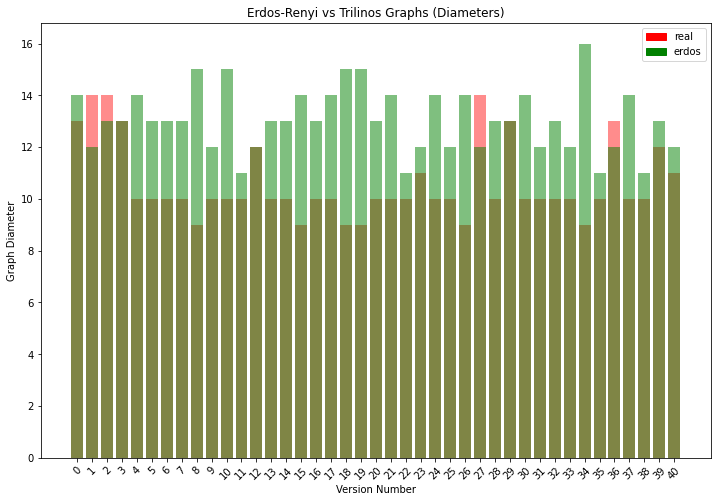

In [95]:
fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=1)
colors = {'real':'red', 'erdos':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)
ax.bar(x=versions, height=X, color='r', alpha=0.45) 
ax.bar(height=y, x=versions, alpha=0.5, color='g')
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_title('Erdos-Renyi vs Trilinos Graphs (Diameters)') 
ax.set_ylabel('Graph Diameter') 
ax.set_xlabel('Version Number')
plt.savefig("ErdosVRealDiams.png", bbox_inches='tight')

### Number of Nodes vs Number of Edges

In [97]:
names    = sorted_callgraph_keys 
nodes    = [callgraphs[n].numberOfNodes() for n in names]
connects = [(callgraphs[n].numberOfEdges() / (callgraphs[n].numberOfNodes() - 1)) for n, i in zip(names, nodes)]

In [98]:
s = (np.log(connects[-1]) - np.log(connects[0])) / np.log(nodes[-1]) - np.log(nodes[0])

Text(0, 0.5, 'ln(pN)')

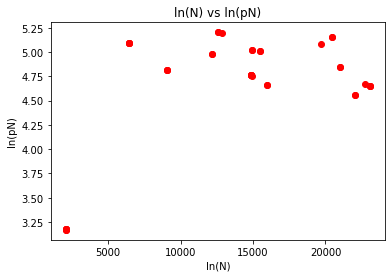

In [99]:
fig = plt.figure() 
ax = plt.gca()
ax.scatter(nodes, connects, color='r')
# ax.plot(np.unique(np.log(sample_pd_fanout.unique_fanouts)), np.poly1d(np.polyfit(np.log(sample_pd_fanout.unique_fanouts), np.log(sample_pd_fanout.probs), 1))(np.unique(np.log(sample_pd_fanout.unique_fanouts))), ':')
# ax.set_yscale('log') 
# ax.set_xscale('log')
ax.set_title('ln(N) vs ln(pN)')
ax.set_xlabel('ln(N)') 
ax.set_ylabel('ln(pN)')

# Barabasi-Albert Model Exploration

In [100]:
from datetime import date, timedelta 

In [101]:
earliest_date = date(2013, 7, 11)
latest_date   = date(2021, 10, 29)
elapsed_date  = latest_date - earliest_date 
elapsed_days  = elapsed_date.days
elapsed_days

3032

In [102]:
elapsed_hours = elapsed_days * 24 
elapsed_hours

72768

In [103]:
def make_diffs(l): 
    return list(map(lambda x: x[1] - x[0], zip(l, l[1:] + [l[-1]])))

In [104]:
diff_nodes = make_diffs(nodes)
mean_nodes = sum(diff_nodes) / len(diff_nodes)

In [105]:
diff_edges = make_diffs(sorted_gr_sizes_edges) 

In [106]:
mean_edges = sum(diff_edges) / len(diff_edges)
mean_edges

2323.3414634146343

In [107]:
daily_edges = mean_edges / 90 # assume mean release time 3 months
daily_edges

25.81490514905149

In [108]:
diff_edges_frac = [c / sorted_gr_sizes_edges[i] for i, c in enumerate(diff_edges)]

In [109]:
sorted_fan_ins = [callgraphMetrics[f].FanIn.sum() for i, f in enumerate(sorted_callgraphMetrics_keys)]

In [110]:
sorted_fan_outs = [callgraphMetrics[f].FanOut.sum() for i, f in enumerate(sorted_callgraphMetrics_keys)]

In [111]:
fan_in_diffs = make_diffs(sorted_fan_ins)

In [112]:
mean_new_ins = sum(fan_in_diffs) / len(fan_in_diffs)

In [113]:
mean_new_ins

2325.170731707317

In [114]:
mean_new_ins / 90

25.835230352303522

In [115]:
M = mean_new_ins / mean_nodes 
M 

5.036027469624933

In [116]:
bag = nk.generators.BarabasiAlbertGenerator(k=M, nMax=nodes[-1], n0=nodes[0])

In [117]:
bagG = bag.generate()

In [118]:
nk.overview(bagG)

Network Properties:
nodes, edges			21020, 96740
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.000438
clustering coefficient		0.000894
min/max/avg degree		2, 73, 9.204567
degree assortativity		0.178372
number of connected components	1
size of largest component	21020 (100.00 %)


In [119]:
nk.overview(callgraphs[sorted_callgraph_keys[-1]])

Network Properties:
nodes, edges			21020, 101875
directed?			True
weighted?			False
isolated nodes			2983
self-loops			258
density				0.000230
min/max/avg degree		0, 294, 4.846575
degree assortativity		0.058990
number of connected components	20979
size of largest component	7 (0.03 %)


In [120]:
sorted_callgraph_keys

['/logs/TrilinosGRJul11th2013.TabOne',
 '/logs/TrilinosGROct23rd2013.TabOne',
 '/logs/TrilinosGRJan14th2014.TabOne',
 '/logs/TrilinosGRJan29th2014.TabOne',
 '/logs/TrilinosGRApr29th2014.TabOne',
 '/logs/TrilinosGRMay16th2014.TabOne',
 '/logs/TrilinosGRJul15th2014.TabOne',
 '/logs/TrilinosGRAug5th2014.TabOne',
 '/logs/TrilinosGROct8th2014.TabOne',
 '/logs/TrilinosGROct23rd2014.TabOne',
 '/logs/TrilinosGRJan22nd2015.TabOne',
 '/logs/TrilinosGRMar6th2015.TabOne',
 '/logs/TrilinosGRApr16th2015.TabOne',
 '/logs/TrilinosGRApr21st2015.TabOne',
 '/logs/TrilinosGRMay7th2015.TabOne',
 '/logs/TrilinosGRJul14th2015.TabOne',
 '/logs/TrilinosGRAug6th2015.TabOne',
 '/logs/TrilinosGROct6th2015.TabOne',
 '/logs/TrilinosGRNov3rd2015.TabOne',
 '/logs/TrilinosGRNov12th2015.TabOne',
 '/logs/TrilinosGRJan12th2016.TabOne',
 '/logs/TrilinosGRJan28th2016.TabOne',
 '/logs/TrilinosGRFeb9th2016.TabOne',
 '/logs/TrilinosGRApr21st2016.TabOne',
 '/logs/TrilinosGRApr28th2016.TabOne',
 '/logs/TrilinosGRJul12th2016.Tab

---

In [121]:
current      = sorted_callgraph_keys[-2]
prev_current = sorted_callgraph_keys[-3]

In [122]:
common_funcs = [] 
for i in callgraphs[current].iterNodes(): 
    if i in callgraphs[prev_current].iterNodes(): 
        common_funcs.append(i)
len(common_funcs)

20301

In [123]:
diff_funcs = [] 
for i in callgraphs[current].iterNodes(): 
    if not (i in common_funcs): 
        diff_funcs.append(i) 
len(diff_funcs)

701

In [124]:
delta_k = callgraphs[current].numberOfEdges() - callgraphs[prev_current].numberOfEdges() 

In [125]:
k_i       = [callgraphs[prev_current].degreeIn(n) for n in common_funcs]

In [126]:
delta_k_i = [(callgraphs[current].degreeIn(n) - callgraphs[prev_current].degreeIn(n)) / delta_k for n in common_funcs]

In [127]:
no_pref = [k / sum(k_i) for k in k_i]

In [128]:
sorted_i = sorted(k_i, reverse=True)

In [134]:
pref_top_10 = [k / sum(sorted_i[:10]) for k in k_i]
pref_top_20 = [k / sum(sorted_i[:20]) for k in k_i]
pref_top_5 = [k / sum(sorted_i[:5]) for k in k_i]

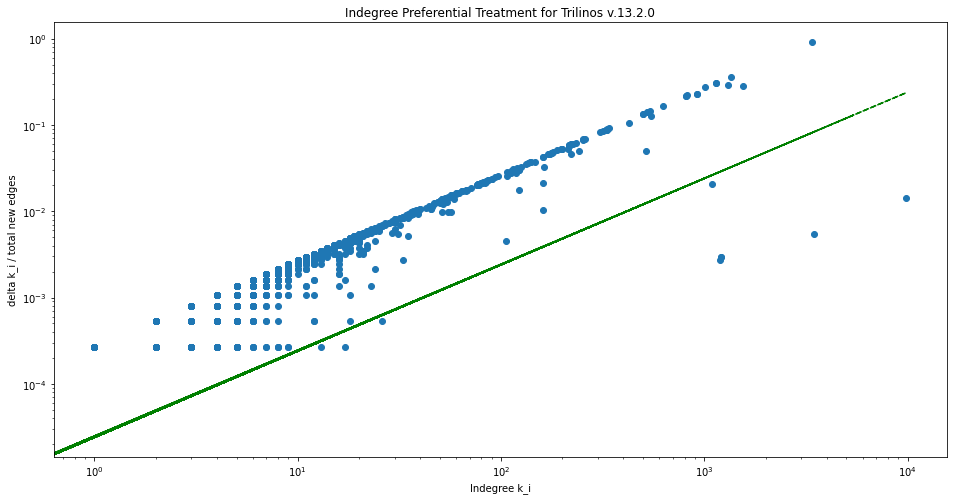

In [135]:
fig = plt.figure(figsize=(16, 8)) 
ax = plt.gca()
plt.scatter(y=delta_k_i, x=k_i)
plt.plot(k_i, pref_top_20, color='green', linestyle='dashed')
ax.set_yscale('log') 
ax.set_xscale('log')
ax.set_title('Indegree Preferential Treatment for Trilinos v.13.2.0')
ax.set_xlabel('Indegree k_i') 
ax.set_ylabel('delta k_i / total new edges')
plt.savefig('IndegreePreferentialTreatment.png')

In [131]:
points = list(zip(k_i, delta_k_i))

In [132]:
points

[(0, -0.0),
 (2, -0.0),
 (1071, -0.016921837228041903),
 (984, -0.0083266183185603),
 (516, -0.023099650819231803),
 (9820, 0.014235831318828902),
 (465, -0.038947085683588505),
 (732, -0.015041633091592801),
 (720, -0.019339242546333603),
 (642, -0.016921837228041903),
 (1368, -0.0316948697287134),
 (1206, 0.0029546065001343),
 (886, -0.0040290088638195),
 (138, -0.0026860059092130005),
 (1206, 0.0029546065001343),
 (1188, 0.0026860059092130005),
 (0, -0.0),
 (43, -0.0008058017727639),
 (0, -0.0),
 (0, -0.0),
 (462, -0.0220252484555466),
 (462, -0.0220252484555466),
 (0, -0.0),
 (0, -0.0),
 (56, -0.0021488047273704003),
 (860, -0.08004297609454741),
 (0, -0.0),
 (0, -0.0),
 (1628, -0.037335482138060705),
 (1, -0.0),
 (3461, 0.005372011818426001),
 (4, -0.0),
 (0, -0.0),
 (1, -0.0),
 (3, -0.0),
 (3, -0.0),
 (45, -0.0),
 (0, -0.0),
 (1, -0.0),
 (2, -0.0),
 (2, -0.0),
 (0, -0.0),
 (1, -0.0),
 (1, -0.0),
 (124, -0.0045662100456621),
 (31, -0.0010744023636852001),
 (1085, 0.020413644910018

In [133]:
x = points[5]
y = points[11] 
slope = log(y[1]/x[1]) / log(y[0]/x[0])
slope

NameError: name 'log' is not defined